In [ ]:
# 图谱质量结果表格对比
import json
import pandas as pd
i = 2

def load_kg_quality_row(json_path, method_name):
    """
    从 KG quality eval json 中抽取 relaxed 评估指标
    """
    with open(json_path, "r", encoding="utf-8") as f:
        metrics = json.load(f)

    # metric_name -> value 映射
    metric_dict = {m["metric_name"]: m["value"] for m in metrics}

    row = {
        "Method": method_name,
        "Prec_E": round(metric_dict["relaxed_entity_precision"], 3),
        "Rec_E":  round(metric_dict["relaxed_entity_recall"], 3),
        "F1_E":   round(metric_dict["relaxed_entity_f1"], 3),
        "Prec_R": round(metric_dict["relaxed_relation_precision"], 3),
        "Rec_R":  round(metric_dict["relaxed_relation_recall"], 3),
        "F1_R":   round(metric_dict["relaxed_relation_f1"], 3),
    }
    return row

row_KG1 = load_kg_quality_row(
    r"D:\Desktop\KG_allprocess\Output\Step7_output\test"+str(i)+"_KG_quality.json",
    r"$\mathcal{M}_{K}^{(1)}$"
)

row_KG2 = load_kg_quality_row(
    r"D:\Desktop\KG_allprocess\Output\Step13_output\test"+str(i)+"_KG_quality_updated.json",
    r"$\mathcal{M}_{K}^{(2)}$"
)

print(row_KG1)
print(row_KG2)

df_kg = pd.DataFrame([row_KG1, row_KG2])
df_kg


{'Method': '$\\mathcal{M}_{K}^{(1)}$', 'Prec_E': 0.769, 'Rec_E': 0.732, 'F1_E': 0.75, 'Prec_R': 0.25, 'Rec_R': 0.158, 'F1_R': 0.194}
{'Method': '$\\mathcal{M}_{K}^{(2)}$', 'Prec_E': 0.773, 'Rec_E': 0.829, 'F1_E': 0.8, 'Prec_R': 0.429, 'Rec_R': 0.316, 'F1_R': 0.364}


,Method,Prec_E,Rec_E,F1_E,Prec_R,Rec_R,F1_R
0,$\mathcal{M}_{K}^{(1)}$,0.769,0.732,0.75,0.250,0.158,0.194
1,$\mathcal{M}_{K}^{(2)}$,0.773,0.829,0.80,0.429,0.316,0.364


In [ ]:
import os
import json
import pandas as pd
i = 2

def load_kg_quality_row(json_path, method_name, i=None):
    """从 KG quality eval json 中抽取 relaxed 评估指标"""
    with open(json_path, "r", encoding="utf-8") as f:
        metrics = json.load(f)

    metric_dict = {m["metric_name"]: m["value"] for m in metrics}

    row = {
        "i": i,
        "Method": method_name,
        "Prec_E": round(metric_dict["relaxed_entity_precision"], 3),
        "Rec_E":  round(metric_dict["relaxed_entity_recall"], 3),
        "F1_E":   round(metric_dict["relaxed_entity_f1"], 3),
        "Prec_R": round(metric_dict["relaxed_relation_precision"], 3),
        "Rec_R":  round(metric_dict["relaxed_relation_recall"], 3),
        "F1_R":   round(metric_dict["relaxed_relation_f1"], 3),
    }
    return row

# ====== 你的路径模板 ======
path_KG1_tpl = r"D:\Desktop\KG_allprocess\Output\Step7_output\test{i}_KG_quality.json"
path_KG2_tpl = r"D:\Desktop\KG_allprocess\Output\Step13_output\test{i}_KG_quality_updated.json"

# ====== 选择要跑哪些 i ======
# 方式1：比如 test1~test20
i_list = list(range(1, 7))

# 如果你只想跑某几个：i_list = [2,3,7,9]

rows = []

for i in i_list:
    p1 = path_KG1_tpl.format(i=i)
    p2 = path_KG2_tpl.format(i=i)

    # KG1
    if os.path.exists(p1):
        rows.append(load_kg_quality_row(p1, r"$\mathcal{M}_{K}^{(1)}$", i=i))
    else:
        print(f"[WARN] missing: {p1}")

    # KG2
    if os.path.exists(p2):
        rows.append(load_kg_quality_row(p2, r"$\mathcal{M}_{K}^{(2)}$", i=i))
    else:
        print(f"[WARN] missing: {p2}")

df_kg = pd.DataFrame(rows).sort_values(["i", "Method"]).reset_index(drop=True)
print(df_kg)

# 可选：导出
# df_kg.to_csv(r"D:\Desktop\kg_quality_batch.csv", index=False, encoding="utf-8-sig")
# df_kg.to_excel(r"D:\Desktop\kg_quality_batch.xlsx", index=False)

mean_by_method = (
    df_kg
    .groupby("Method", as_index=False)
    .mean(numeric_only=True)
)

print(mean_by_method)
# wide.to_excel(r"D:\Desktop\kg_quality_batch_wide.xlsx", index=False)


    i                   Method  Prec_E  Rec_E   F1_E  Prec_R  Rec_R   F1_R
0   1  $\mathcal{M}_{K}^{(1)}$   0.799  0.825  0.812   0.182  0.159  0.170
1   1  $\mathcal{M}_{K}^{(2)}$   0.801  0.882  0.839   0.296  0.304  0.300
2   2  $\mathcal{M}_{K}^{(1)}$   0.769  0.732  0.750   0.250  0.158  0.194
3   2  $\mathcal{M}_{K}^{(2)}$   0.773  0.829  0.800   0.429  0.316  0.364
4   3  $\mathcal{M}_{K}^{(1)}$   0.837  0.837  0.837   0.133  0.094  0.111
5   3  $\mathcal{M}_{K}^{(2)}$   0.836  0.886  0.860   0.315  0.276  0.294
6   4  $\mathcal{M}_{K}^{(1)}$   0.787  0.798  0.792   0.279  0.243  0.259
7   4  $\mathcal{M}_{K}^{(2)}$   0.786  0.856  0.820   0.379  0.379  0.379
8   5  $\mathcal{M}_{K}^{(1)}$   0.714  0.833  0.769   0.114  0.091  0.101
9   5  $\mathcal{M}_{K}^{(2)}$   0.719  0.885  0.793   0.279  0.273  0.276
10  6  $\mathcal{M}_{K}^{(1)}$   0.685  0.730  0.706   0.225  0.158  0.186
11  6  $\mathcal{M}_{K}^{(2)}$   0.695  0.809  0.747   0.340  0.281  0.308
                    Metho

In [ ]:
# 问题评估结果表格对比
import json
import pandas as pd

def load_eval_row(json_path, method_name):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    row = {
        "Method": method_name,
        "A(q)": round(data["avg_A"], 2),
        "B(q)": round(data["avg_B"], 2),
        "C(q)": round(data["avg_C"], 2),
        "D(q)": round(data["avg_D"], 2),
        "Q(q)": round(data["avg_Q_total"], 2),
        "S(Q^(t))": round(data["suggested_suite_total_with_distribution"], 2)
    }
    return row


row_MQ1 = load_eval_row(
    r"D:\Desktop\KG_allprocess\Output\Step9_output\test"+str(i)+"_MCQ_eval.json",
    r"$\mathcal{M}_{Q}^{(1)}$"
)

row_MQ2 = load_eval_row(
    r"D:\Desktop\KG_allprocess\Output\Step15_output\test"+str(i)+"_MCQ_eval_updated.json",
    r"$\mathcal{M}_{Q}^{(2)}$"
)

print(row_MQ1)
print(row_MQ2)

df = pd.DataFrame([row_MQ1, row_MQ2])
df

{'Method': '$\\mathcal{M}_{Q}^{(1)}$', 'A(q)': 93.33, 'B(q)': 87.5, 'C(q)': 75.0, 'D(q)': 75.0, 'Q(q)': 82.71, 'S(Q^(t))': 85.29}
{'Method': '$\\mathcal{M}_{Q}^{(2)}$', 'A(q)': 87.33, 'B(q)': 84.33, 'C(q)': 80.0, 'D(q)': 80.0, 'Q(q)': 82.92, 'S(Q^(t))': 80.42}


,Method,A(q),B(q),C(q),D(q),Q(q),S(Q^(t))
0,$\mathcal{M}_{Q}^{(1)}$,93.33,87.50,75.0,75.0,82.71,85.29
1,$\mathcal{M}_{Q}^{(2)}$,87.33,84.33,80.0,80.0,82.92,80.42


In [ ]:
# 问题评估结果：批量计算 + 平均
import os
import json
import pandas as pd

def load_eval_row(json_path, method_name, i=None):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    row = {
        "i": i,
        "Method": method_name,
        "A(q)": round(data["avg_A"], 2),
        "B(q)": round(data["avg_B"], 2),
        "C(q)": round(data["avg_C"], 2),
        "D(q)": round(data["avg_D"], 2),
        "Q(q)": round(data["avg_Q_total"], 2),
        "S(Q^(t))": round(data["suggested_suite_total_with_distribution"], 2)
    }
    return row


# ===== 路径模板 =====
path_MQ1_tpl = r"D:\Desktop\KG_allprocess\Output\Step9_output\test{i}_MCQ_eval.json"
path_MQ2_tpl = r"D:\Desktop\KG_allprocess\Output\Step15_output\test{i}_MCQ_eval_updated.json"

# ===== 要跑的 i =====
i_list = list(range(2, 7))   # 例如 test2 ~ test6

rows = []

for i in i_list:
    p1 = path_MQ1_tpl.format(i=i)
    p2 = path_MQ2_tpl.format(i=i)

    if os.path.exists(p1):
        rows.append(load_eval_row(p1, r"$\mathcal{M}_{Q}^{(1)}$", i))
    else:
        print(f"[WARN] missing: {p1}")

    if os.path.exists(p2):
        rows.append(load_eval_row(p2, r"$\mathcal{M}_{Q}^{(2)}$", i))
    else:
        print(f"[WARN] missing: {p2}")

df_eval = pd.DataFrame(rows).sort_values(["i", "Method"]).reset_index(drop=True)

print(df_eval)

mean_by_method = (
    df_eval
    .groupby("Method", as_index=False)
    .mean(numeric_only=True)
    .round(2)
)

print(mean_by_method)


   i                   Method   A(q)   B(q)  C(q)  D(q)   Q(q)  S(Q^(t))
0  2  $\mathcal{M}_{Q}^{(1)}$  93.33  87.50  75.0  75.0  82.71     85.29
1  2  $\mathcal{M}_{Q}^{(2)}$  87.33  84.33  80.0  80.0  82.92     80.42
2  3  $\mathcal{M}_{Q}^{(1)}$  81.20  83.56  74.0  76.0  78.69     74.81
3  3  $\mathcal{M}_{Q}^{(2)}$  80.80  83.86  72.0  72.0  77.17     75.10
4  4  $\mathcal{M}_{Q}^{(1)}$  82.40  82.00  40.0  56.0  65.10     68.26
5  4  $\mathcal{M}_{Q}^{(2)}$  83.40  81.56  48.0  60.0  68.24     71.74
                    Method    i   A(q)   B(q)   C(q)   D(q)   Q(q)  S(Q^(t))
0  $\mathcal{M}_{Q}^{(1)}$  3.0  85.64  84.35  63.00  69.00  75.50     76.12
1  $\mathcal{M}_{Q}^{(2)}$  3.0  83.84  83.25  66.67  70.67  76.11     75.75


In [12]:
import pandas as pd
import networkx as nx

def load_kg_from_tsv(
    nodes_tsv,
    edges_tsv,
    directed=True,
    # ——节点ID列：如果你 nodes 表不是 id，就改这里，比如 node_id / entity_id
    node_id_col="id",
    # ——边表列：按你文件的真实列名写死
    src_col="src_id",
    dst_col="dst_id",
    rel_col="relation_type",
    # ——可选：把 confidence 一起读进来
    conf_col="confidence"
):
    nodes = pd.read_csv(nodes_tsv, sep="\t")
    edges = pd.read_csv(edges_tsv, sep="\t")

    if node_id_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到 node_id_col='{node_id_col}'，当前列={list(nodes.columns)}")
    for c in [src_col, dst_col]:
        if c not in edges.columns:
            raise ValueError(f"[edges] 找不到列 '{c}'，当前列={list(edges.columns)}")
    if rel_col is not None and rel_col not in edges.columns:
        raise ValueError(f"[edges] 找不到 rel_col='{rel_col}'，当前列={list(edges.columns)}")

    G = nx.DiGraph() if directed else nx.Graph()

    # 节点
    for _, r in nodes.iterrows():
        nid = str(r[node_id_col])
        G.add_node(nid, **r.to_dict())

    # 边
    for _, r in edges.iterrows():
        u = str(r[src_col])
        v = str(r[dst_col])
        rel = str(r[rel_col]) if rel_col else ""
        attrs = {"relation": rel}

        # 可选保存 confidence
        if conf_col in edges.columns:
            attrs["confidence"] = float(r[conf_col]) if pd.notna(r[conf_col]) else None

        G.add_edge(u, v, **attrs)

    return G


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

def edge_keyset(G):
    s = set()
    for u, v, d in G.edges(data=True):
        s.add((u, d.get("relation", ""), v))
    return s

def make_union_graph(*graphs):
    U = nx.DiGraph()
    for g in graphs:
        U.add_nodes_from(g.nodes(data=True))
        U.add_edges_from(g.edges(data=True))
    return U

def k_hop_nodes_union_graph(G_union, seeds, k=2, max_nodes=80):
    seeds = [s for s in seeds if s in G_union]
    if not seeds:
        return set()

    visited = set(seeds)
    q = deque([(s, 0) for s in seeds])

    while q:
        node, dist = q.popleft()
        if dist == k:
            continue

        neighbors = set(G_union.successors(node)) | set(G_union.predecessors(node))
        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))
                if max_nodes is not None and len(visited) >= max_nodes:
                    return visited
    return visited

def draw_graph(ax, G, pos, title):
    ax.set_title(title)
    ax.axis("off")
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=520)
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=12, width=1.4)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=9)

def draw_update_diff(ax, G_base, G_upd, pos, title="Diff (focus): Baseline → Updated"):
    ax.set_title(title)
    ax.axis("off")

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added = upd_edges - base_edges
    removed = base_edges - upd_edges
    kept = base_edges & upd_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    all_nodes = set(G_base.nodes()) | set(G_upd.nodes())
    nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(all_nodes), node_size=520)

    # 不指定颜色：用线型和粗细突出变化
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(kept),    width=1.0, alpha=0.35)
    nx.draw_networkx_edges(G_upd,  pos, ax=ax, edgelist=_to_uv(added),   width=3.2, alpha=0.9)
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(removed), style="dashed", width=2.6, alpha=0.9)

    nx.draw_networkx_labels(G_upd, pos, ax=ax, font_size=9)
    ax.text(0.01, 0.01,
            f"added_edges={len(added)}, removed_edges={len(removed)}, kept_edges={len(kept)}",
            transform=ax.transAxes, fontsize=9, va="bottom")

def plot_focus_subgraph(
    base_nodes, base_edges,
    upd_nodes, upd_edges,
    truth_nodes, truth_edges,
    node_id_col="id",     # 如果 nodes 表不是 id，就改这里
    k=2,
    max_nodes=80,
    out_path="kg_focus_update.png",
    seed=42
):
    # ✅ 按你 edges 表列名读取：src_id/dst_id/relation_type
    G_base  = load_kg_from_tsv(base_nodes,  base_edges,  node_id_col=node_id_col)
    G_upd   = load_kg_from_tsv(upd_nodes,   upd_edges,   node_id_col=node_id_col)
    G_truth = load_kg_from_tsv(truth_nodes, truth_edges, node_id_col=node_id_col)

    base_e = edge_keyset(G_base)
    upd_e  = edge_keyset(G_upd)

    added = upd_e - base_e
    removed = base_e - upd_e

    # 变化中心节点：变化边两端
    changed_nodes = set()
    for (u, rel, v) in list(added) + list(removed):
        changed_nodes.add(u); changed_nodes.add(v)

    G_union = make_union_graph(G_base, G_upd, G_truth)
    focus_nodes = k_hop_nodes_union_graph(G_union, changed_nodes, k=k, max_nodes=max_nodes)

    base_sub  = G_base.subgraph(focus_nodes).copy()
    upd_sub   = G_upd.subgraph(focus_nodes).copy()
    truth_sub = G_truth.subgraph(focus_nodes).copy()

    union_sub = make_union_graph(base_sub, upd_sub, truth_sub)
    pos = nx.spring_layout(union_sub, seed=seed)

    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0]); draw_graph(ax1, base_sub,  pos, f"Baseline (focus, k={k})")
    ax2 = fig.add_subplot(gs[0, 1]); draw_graph(ax2, upd_sub,   pos, f"Updated (focus, k={k})")
    ax3 = fig.add_subplot(gs[1, 0]); draw_graph(ax3, truth_sub, pos, f"Truth (focus, k={k})")
    ax4 = fig.add_subplot(gs[1, 1]); draw_update_diff(ax4, base_sub, upd_sub, pos)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

    print(f"[Saved] {out_path}")
    print(f"[Focus] changed_nodes={len(changed_nodes)}, focus_nodes={len(focus_nodes)} (k={k}, max_nodes={max_nodes})")


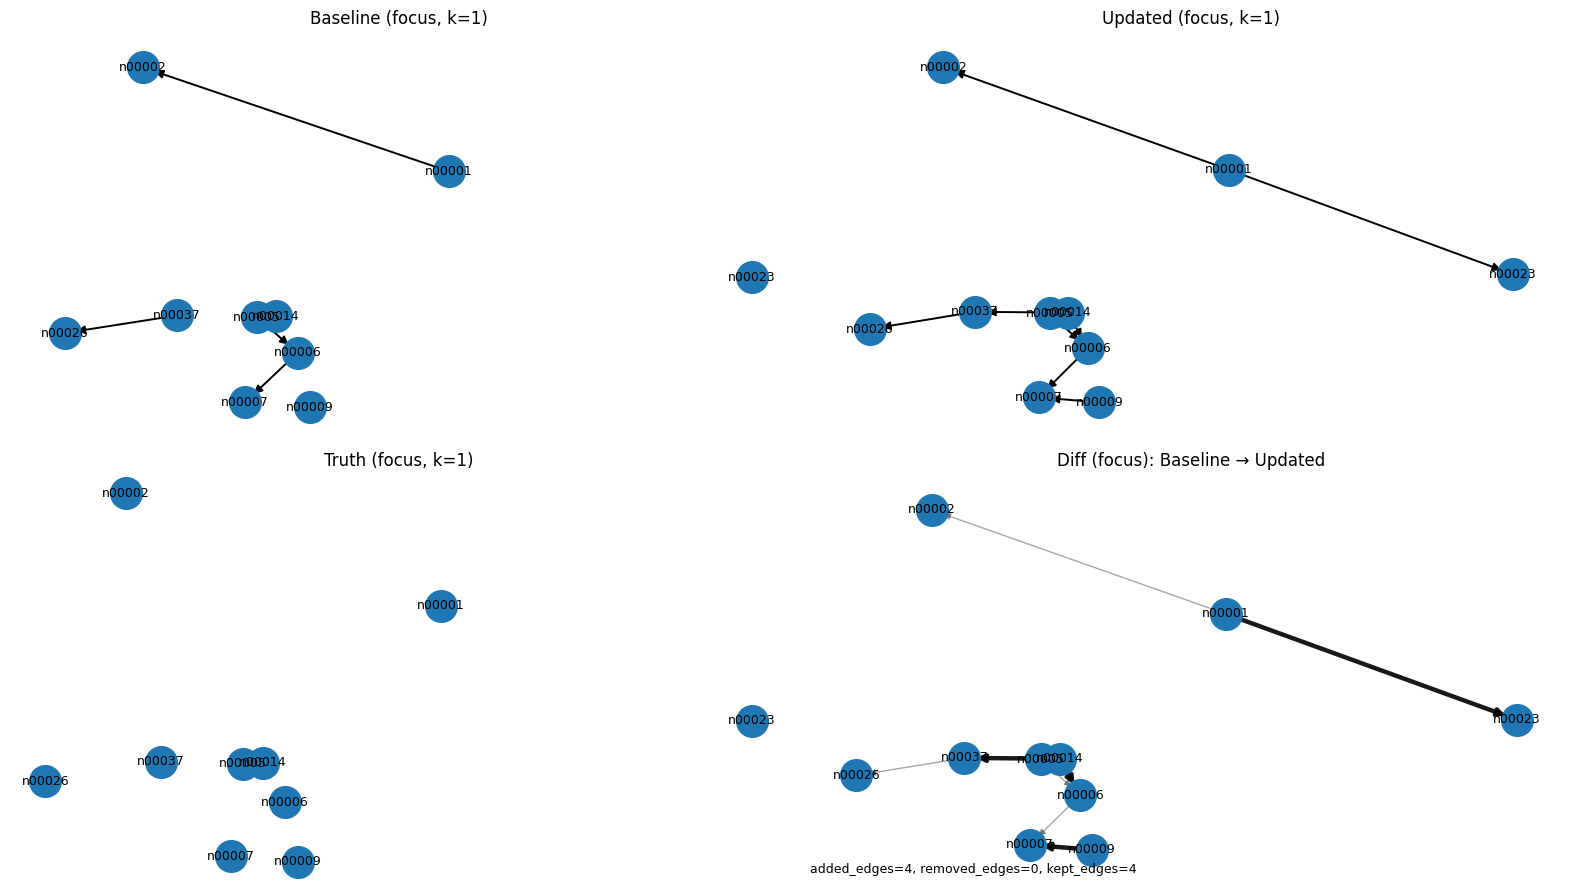

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_update.png
[Focus] changed_nodes=7, focus_nodes=10 (k=1, max_nodes=10)


In [19]:

# ---------------------------
# 4) 你只需要填路径
# ---------------------------
i = 2

plot_focus_subgraph(
    base_nodes=r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_nodes.tsv",
    base_edges=r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_edges.tsv",

    upd_nodes=r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_nodes_updated.tsv",
    upd_edges=r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_edges_updated.tsv",

    truth_nodes=r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_nodes.tsv",
    truth_edges=r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_edges.tsv",
    
    node_id_col="node_id",
    k=1,              # 推荐 1~3；k 越大，范围越广
    max_nodes=10,     # 防止图太大；你可以调小到 30~60 更聚焦
    out_path="D:\\Desktop\\KG_allprocess\\Output\\Step5_output\\Figures\\test"+str(i)+"_kg_focus_update.png",
)


In [21]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# =========================================================
# 0) 你只需要改这里：三套图谱的 nodes/edges 路径
# =========================================================
i = 2

BASE_NODES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_nodes.tsv"
BASE_EDGES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_edges.tsv"

UPD_NODES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_nodes_updated.tsv"
UPD_EDGES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_edges_updated.tsv"
# 真值图谱路径（按你实际文件改）
TRUTH_NODES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_nodes.tsv"
TRUTH_EDGES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_edges.tsv"

# 输出图片保存路径（确保目录存在）
OUT_PATH    = r"D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test"+str(i)+"_kg_focus_update.png"
# 聚焦参数：k 越大范围越广；max_nodes 越小越聚焦
K_HOP       = 1
MAX_NODES   = 10

# 你的列名已知：nodes里实体名列是 name；edges里 src_id/dst_id/relation_type
NODE_NAME_COL = "name"
EDGE_SRC_COL  = "src_id"
EDGE_DST_COL  = "dst_id"
EDGE_REL_COL  = "relation_type"

# nodes 表中“节点ID列”你如果不确定，下面会自动猜；也可以写死比如 "id" / "node_id"
NODE_ID_COL_CANDIDATES = ["id", "node_id", "entity_id", "nid"]


# =========================================================
# 1) 读取图谱：NetworkX (DiGraph)
# =========================================================
def load_kg_from_tsv(
    nodes_tsv,
    edges_tsv,
    directed=True,
    node_id_col=None,
    node_name_col="name",
    src_col="src_id",
    dst_col="dst_id",
    rel_col="relation_type",
):
    nodes = pd.read_csv(nodes_tsv, sep="\t")
    edges = pd.read_csv(edges_tsv, sep="\t")

    # 自动确定 node_id_col
    if node_id_col is None:
        for cand in NODE_ID_COL_CANDIDATES:
            if cand in nodes.columns:
                node_id_col = cand
                break
    if node_id_col is None or node_id_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到节点ID列。当前列={list(nodes.columns)}；请把 node_id_col 写死成其中一列。")

    # 检查必要列
    for c in [src_col, dst_col, rel_col]:
        if c not in edges.columns:
            raise ValueError(f"[edges] 找不到列 '{c}'，当前列={list(edges.columns)}")

    if node_name_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到实体名列 '{node_name_col}'，当前列={list(nodes.columns)}")

    G = nx.DiGraph() if directed else nx.Graph()

    # 节点：存 display_name，用于绘图
    for _, r in nodes.iterrows():
        nid = str(r[node_id_col])
        attrs = r.to_dict()
        attrs["display_name"] = str(r[node_name_col]) if pd.notna(r[node_name_col]) else nid
        G.add_node(nid, **attrs)

    # 边：存 relation（来自 relation_type）
    for _, r in edges.iterrows():
        u = str(r[src_col])
        v = str(r[dst_col])
        rel = str(r[rel_col]) if pd.notna(r[rel_col]) else ""
        G.add_edge(u, v, relation=rel)

    return G


def edge_keyset(G):
    """把边映射成 (u, relation, v) 的集合，便于做差分/TP FP FN 等"""
    s = set()
    for u, v, d in G.edges(data=True):
        s.add((u, d.get("relation", ""), v))
    return s


def make_union_graph(*graphs):
    """联合图，用于统一布局/做 k-hop 扩展时不漏邻居"""
    U = nx.DiGraph()
    for g in graphs:
        U.add_nodes_from(g.nodes(data=True))
        U.add_edges_from(g.edges(data=True))
    return U


# =========================================================
# 2) k-hop 聚焦：从变化边端点出发扩展邻域
# =========================================================
def k_hop_nodes(G_union, seeds, k=2, max_nodes=60):
    seeds = [s for s in seeds if s in G_union]
    if not seeds:
        return set()

    visited = set(seeds)
    q = deque([(s, 0) for s in seeds])

    while q:
        node, dist = q.popleft()
        if dist == k:
            continue

        neighbors = set(G_union.successors(node)) | set(G_union.predecessors(node))
        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))
                if max_nodes is not None and len(visited) >= max_nodes:
                    return visited
    return visited


# =========================================================
# 3) 绘图：节点显示 name；边显示 relation_type
# =========================================================
def draw_graph(ax, G, pos, title, node_font_size=9, edge_font_size=8):
    ax.set_title(title)
    ax.axis("off")

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=520)
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=12, width=1.4)

    node_labels = {n: G.nodes[n].get("display_name", str(n)) for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, ax=ax, labels=node_labels, font_size=node_font_size)

    edge_labels = {(u, v): d.get("relation", "") for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels, font_size=edge_font_size)


def draw_update_diff(ax, G_base, G_upd, pos, title="Diff (focus): Baseline → Updated"):
    ax.set_title(title)
    ax.axis("off")

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added   = upd_edges - base_edges
    removed = base_edges - upd_edges
    kept    = base_edges & upd_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    all_nodes = set(G_base.nodes()) | set(G_upd.nodes())
    nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(all_nodes), node_size=520)

    # 不指定颜色：用线型+粗细突出变化
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(kept),    width=1.0, alpha=0.25)
    nx.draw_networkx_edges(G_upd,  pos, ax=ax, edgelist=_to_uv(added),   width=3.2, alpha=0.9)
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(removed), style="dashed", width=2.6, alpha=0.9)

    # 节点标签：实体 name
    node_labels = {n: G_upd.nodes[n].get("display_name", str(n)) for n in all_nodes}
    nx.draw_networkx_labels(G_upd, pos, ax=ax, labels=node_labels, font_size=9)

    # 只给变化边打标签（更清晰、更突出更新）
    change_edge_labels = {}
    for (u, rel, v) in added:
        change_edge_labels[(u, v)] = rel
    for (u, rel, v) in removed:
        change_edge_labels[(u, v)] = rel

    nx.draw_networkx_edge_labels(G_upd, pos, ax=ax, edge_labels=change_edge_labels, font_size=8)

    ax.text(
        0.01, 0.01,
        f"added_edges={len(added)}, removed_edges={len(removed)}, kept_edges={len(kept)}",
        transform=ax.transAxes, fontsize=9, va="bottom"
    )


# =========================================================
# 4) 主函数：只画“更新变化附近”的子图
# =========================================================
def plot_focus_update_subgraph(
    base_nodes, base_edges,
    upd_nodes, upd_edges,
    truth_nodes, truth_edges,
    out_path,
    k=2,
    max_nodes=60,
    seed=42
):
    # 读图
    G_base  = load_kg_from_tsv(base_nodes,  base_edges,  node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_upd   = load_kg_from_tsv(upd_nodes,   upd_edges,   node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_truth = load_kg_from_tsv(truth_nodes, truth_edges, node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)

    # 找变化边
    base_e = edge_keyset(G_base)
    upd_e  = edge_keyset(G_upd)
    added = upd_e - base_e
    removed = base_e - upd_e

    # 变化中心节点：变化边端点
    changed_nodes = set()
    for (u, rel, v) in list(added) + list(removed):
        changed_nodes.add(u); changed_nodes.add(v)

    if not changed_nodes:
        print("[Warn] 没有检测到新增/删除边（baseline 与 updated 边集合完全相同）。将画全图可能更合适。")

    # 联合图上做 k-hop
    G_union = make_union_graph(G_base, G_upd, G_truth)
    focus_nodes = k_hop_nodes(G_union, changed_nodes, k=k, max_nodes=max_nodes) if changed_nodes else set(G_union.nodes())

    # 子图
    base_sub  = G_base.subgraph(focus_nodes).copy()
    upd_sub   = G_upd.subgraph(focus_nodes).copy()
    truth_sub = G_truth.subgraph(focus_nodes).copy()

    # 统一布局（在聚焦联合子图上算）
    union_sub = make_union_graph(base_sub, upd_sub, truth_sub)
    pos = nx.spring_layout(union_sub, seed=seed)

    # 画图：2x2
    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0]); draw_graph(ax1, base_sub,  pos, f"Baseline (focus, k={k})")
    ax2 = fig.add_subplot(gs[0, 1]); draw_graph(ax2, upd_sub,   pos, f"Updated (focus, k={k})")
    ax3 = fig.add_subplot(gs[1, 0]); draw_graph(ax3, truth_sub, pos, f"Truth (focus, k={k})")
    ax4 = fig.add_subplot(gs[1, 1]); draw_update_diff(ax4, base_sub, upd_sub, pos)

    plt.tight_layout()

    # 确保目录存在
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.show()

    print(f"[Saved] {out_path}")
    print(f"[Focus] changed_nodes={len(changed_nodes)}, focus_nodes={len(focus_nodes)} (k={k}, max_nodes={max_nodes})")


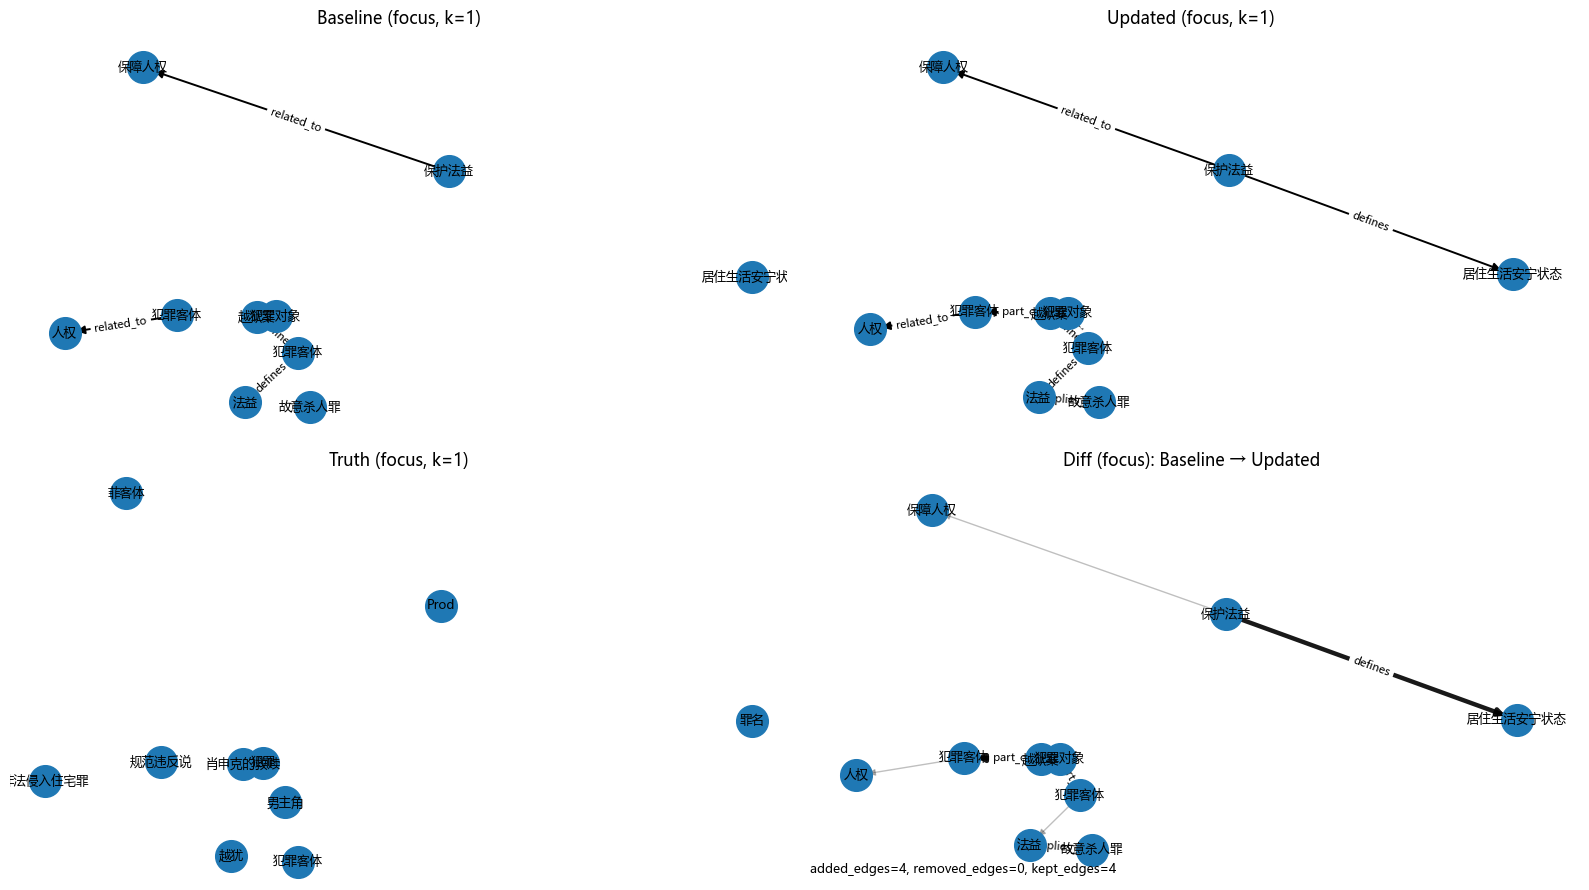

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_update.png
[Focus] changed_nodes=7, focus_nodes=10 (k=1, max_nodes=10)


In [22]:
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
# =========================================================
# 5) 运行
# =========================================================
plot_focus_update_subgraph(
    base_nodes=BASE_NODES, base_edges=BASE_EDGES,
    upd_nodes=UPD_NODES,   upd_edges=UPD_EDGES,
    truth_nodes=TRUTH_NODES, truth_edges=TRUTH_EDGES,
    out_path=OUT_PATH,
    k=K_HOP,
    max_nodes=MAX_NODES
)


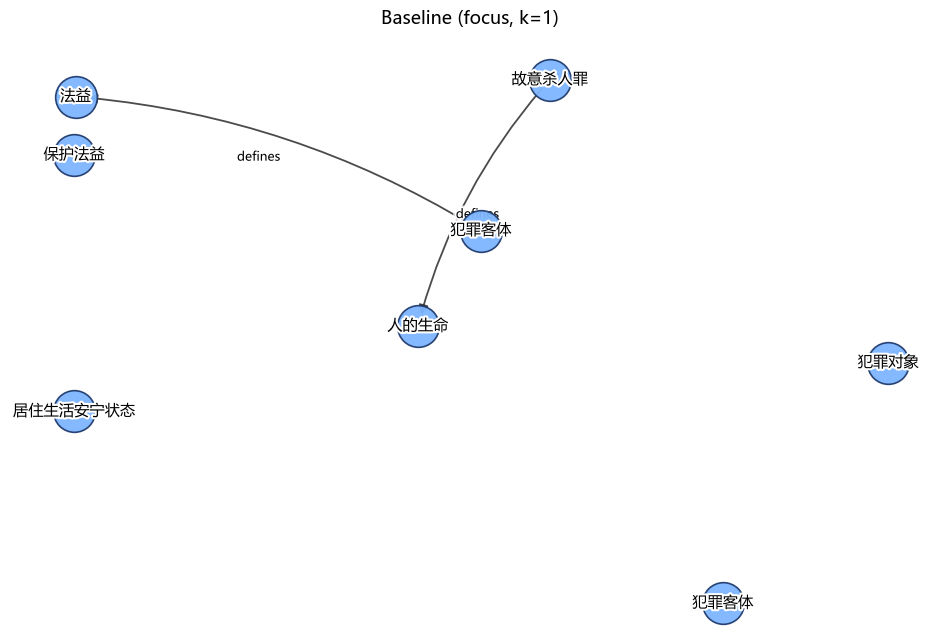

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_baseline.png


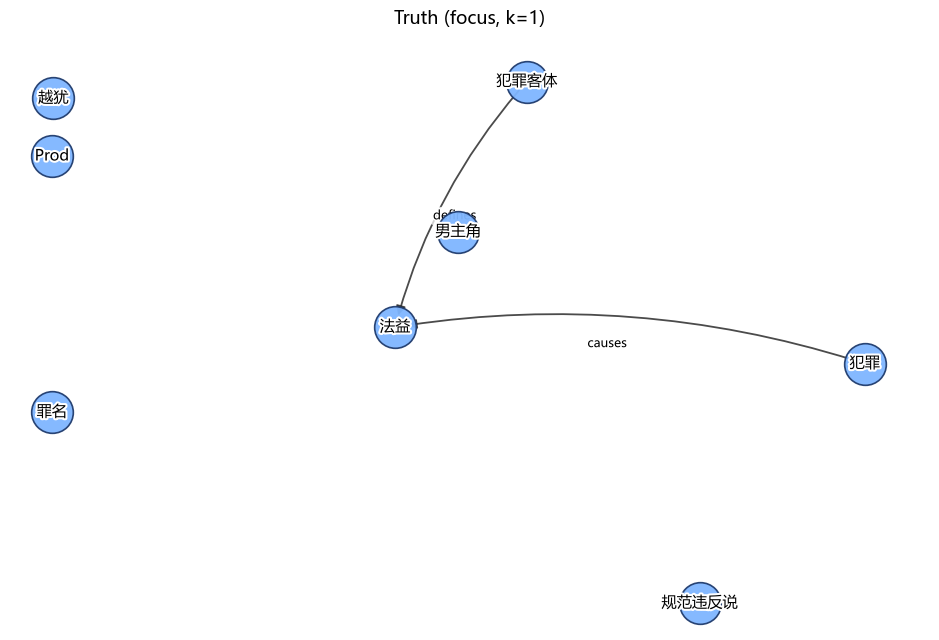

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_truth.png


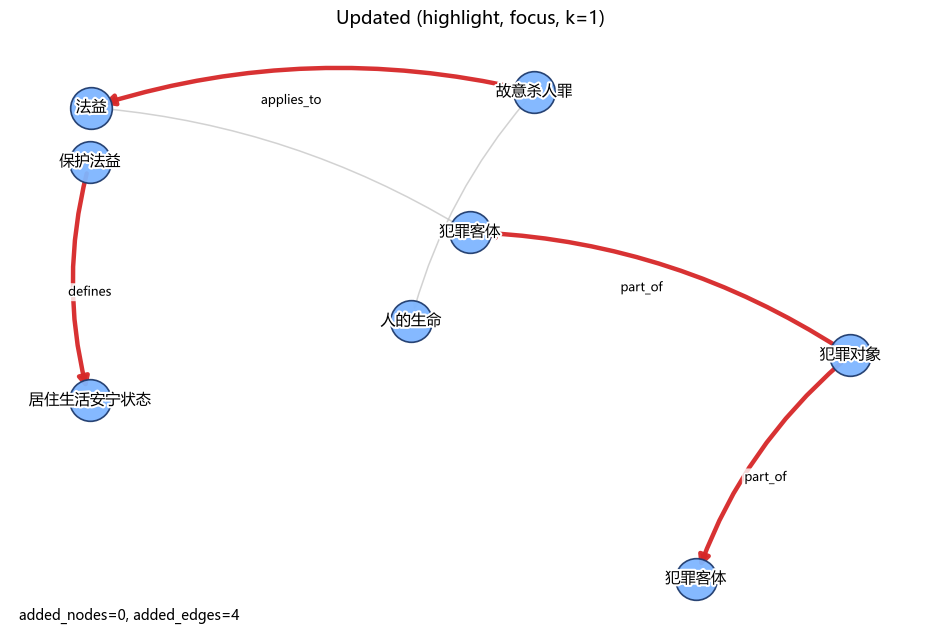

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_updated_highlight.png
[Focus] nodes=8, added_edges=4, removed_edges=0


In [ ]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# =========================================================
# 0) 路径配置
# =========================================================
i = 2

BASE_NODES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_nodes.tsv"
BASE_EDGES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_edges.tsv"

UPD_NODES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_nodes_updated.tsv"
UPD_EDGES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_edges_updated.tsv"

TRUTH_NODES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_nodes.tsv"
TRUTH_EDGES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_edges.tsv"

OUT_DIR     = r"D:\Desktop\KG_allprocess\Output\Step5_output\Figures"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_BASELINE = os.path.join(OUT_DIR, f"test{i}_kg_focus_baseline.png")
OUT_TRUTH    = os.path.join(OUT_DIR, f"test{i}_kg_focus_truth.png")
OUT_UPDATED  = os.path.join(OUT_DIR, f"test{i}_kg_focus_updated_highlight.png")

# 聚焦参数
K_HOP     = 1
MAX_NODES = 10

# 列名
NODE_NAME_COL = "name"
EDGE_SRC_COL  = "src_id"
EDGE_DST_COL  = "dst_id"
EDGE_REL_COL  = "relation_type"
NODE_ID_COL_CANDIDATES = ["id", "node_id", "entity_id", "nid"]

# 中文字体
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


# =========================================================
# 1) 读图
# =========================================================
def load_kg_from_tsv(
    nodes_tsv,
    edges_tsv,
    directed=True,
    node_id_col=None,
    node_name_col="name",
    src_col="src_id",
    dst_col="dst_id",
    rel_col="relation_type",
):
    nodes = pd.read_csv(nodes_tsv, sep="\t")
    edges = pd.read_csv(edges_tsv, sep="\t")

    if node_id_col is None:
        for cand in NODE_ID_COL_CANDIDATES:
            if cand in nodes.columns:
                node_id_col = cand
                break
    if node_id_col is None or node_id_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到节点ID列。当前列={list(nodes.columns)}")

    for c in [src_col, dst_col, rel_col]:
        if c not in edges.columns:
            raise ValueError(f"[edges] 找不到列 '{c}'，当前列={list(edges.columns)}")
    if node_name_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到实体名列 '{node_name_col}'，当前列={list(nodes.columns)}")

    G = nx.DiGraph() if directed else nx.Graph()

    for _, r in nodes.iterrows():
        nid = str(r[node_id_col])
        name = str(r[node_name_col]) if pd.notna(r[node_name_col]) else nid
        name = name.strip()
        if not name:
            name = nid
        attrs = r.to_dict()
        attrs["display_name"] = name
        G.add_node(nid, **attrs)

    for _, r in edges.iterrows():
        u = str(r[src_col])
        v = str(r[dst_col])
        rel = str(r[rel_col]) if pd.notna(r[rel_col]) else ""
        rel = rel.strip()
        if not rel:
            rel = "?"
        G.add_edge(u, v, relation=rel)

    return G


def edge_keyset(G):
    s = set()
    for u, v, d in G.edges(data=True):
        s.add((u, d.get("relation", ""), v))
    return s


def make_union_graph(*graphs):
    U = nx.DiGraph()
    for g in graphs:
        U.add_nodes_from(g.nodes(data=True))
        U.add_edges_from(g.edges(data=True))
    return U


# =========================================================
# 2) k-hop 聚焦
# =========================================================
def k_hop_nodes(G_union, seeds, k=2, max_nodes=60):
    seeds = [s for s in seeds if s in G_union]
    if not seeds:
        return set()

    visited = set(seeds)
    q = deque([(s, 0) for s in seeds])

    while q:
        node, dist = q.popleft()
        if dist == k:
            continue

        neighbors = set(G_union.successors(node)) | set(G_union.predecessors(node))
        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))
                if max_nodes is not None and len(visited) >= max_nodes:
                    return visited
    return visited


# =========================================================
# 3) 绘图函数
# =========================================================
def _node_labels(G):
    return {n: G.nodes[n].get("display_name", str(n)) for n in G.nodes()}

def _edge_labels(G):
    return {(u, v): d.get("relation", "") for u, v, d in G.edges(data=True)}

def draw_plain_graph(G, pos, title, out_path, node_size=650, node_font=10, edge_font=9):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.axis("off")

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, node_color="#1f77b4")
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=14, width=1.6, edge_color="black")

    nx.draw_networkx_labels(G, pos, ax=ax, labels=_node_labels(G), font_size=node_font)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=_edge_labels(G), font_size=edge_font)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"[Saved] {out_path}")


def draw_updated_highlight(G_base, G_upd, pos, title, out_path,
                          node_size=650, node_font=10, edge_font=9):
    """
    Updated 图：高亮新增节点/新增边
    - baseline已有节点：蓝色
    - 新增节点：橙色
    - baseline已有边：浅灰
    - 新增边：红色 + 更粗
    """
    base_nodes = set(G_base.nodes())
    upd_nodes  = set(G_upd.nodes())

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added_nodes = upd_nodes - base_nodes
    kept_nodes  = upd_nodes & base_nodes

    added_edges = upd_edges - base_edges
    kept_edges  = upd_edges & base_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.axis("off")

    # 节点：先画保留，再画新增（新增盖在上面更醒目）
    if kept_nodes:
        nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(kept_nodes),
                               node_size=node_size, node_color="#1f77b4")
    if added_nodes:
        nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(added_nodes),
                               node_size=int(node_size * 1.08), node_color="#ff7f0e")

    # 边：保留边淡灰，新增边红且更粗
    if kept_edges:
        nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(kept_edges),
                               arrows=True, arrowsize=14, width=1.2, edge_color="#b0b0b0", alpha=0.8)
    if added_edges:
        nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(added_edges),
                               arrows=True, arrowsize=16, width=3.0, edge_color="#d62728", alpha=0.95)

    # 标签
    nx.draw_networkx_labels(G_upd, pos, ax=ax, labels=_node_labels(G_upd), font_size=node_font)

    # 只给新增边打关系标签（最突出更新）
    added_edge_labels = {(u, v): rel for (u, rel, v) in added_edges}
    if added_edge_labels:
        nx.draw_networkx_edge_labels(G_upd, pos, ax=ax, edge_labels=added_edge_labels, font_size=edge_font)

    ax.text(0.01, 0.01,
            f"added_nodes={len(added_nodes)}, added_edges={len(added_edges)}",
            transform=ax.transAxes, fontsize=10, va="bottom")

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"[Saved] {out_path}")

import matplotlib.patheffects as pe

def _node_labels(G):
    return {n: G.nodes[n].get("display_name", str(n)) for n in G.nodes()}

def _edge_labels(G):
    return {(u, v): d.get("relation", "") for u, v, d in G.edges(data=True)}

def _best_layout(G, seed=42):
    """
    小图优先用 kamada_kawai，更规整；失败再退 spring。
    """
    try:
        return nx.kamada_kawai_layout(G)
    except Exception:
        return nx.spring_layout(G, seed=seed)

import matplotlib.patheffects as pe

def _draw_labels_with_outline(G, ax, pos, labels, font_size=10):
    texts = nx.draw_networkx_labels(
        G,
        pos,
        ax=ax,
        labels=labels,
        font_size=font_size
    )
    # 白色描边，防止被边压住
    for t in texts.values():
        t.set_path_effects([
            pe.withStroke(linewidth=3, foreground="white")
        ])
    return texts


def draw_plain_graph_beauty(G, pos, title, out_path,
                            node_size=900, node_font=11, edge_font=9):
    fig = plt.figure(figsize=(9.5, 6.5))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=13, pad=12)
    ax.axis("off")

    # 节点：浅蓝 + 深色边框
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=node_size,
        node_color="#7fb6ff",
        edgecolors="#1f3b6d",
        linewidths=1.2,
        alpha=0.95
    )

    # 边：弧形，细一点更清爽
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edge_color="#2b2b2b",
        width=1.3,
        alpha=0.85,
        arrows=True,
        arrowsize=14,
        connectionstyle="arc3,rad=0.12"
    )

    # 节点标签：描边
    _draw_labels_with_outline(G, ax, pos, _node_labels(G), font_size=node_font)


    # 边标签：加半透明白底
    e_labels = _edge_labels(G)
    if e_labels:
        texts = nx.draw_networkx_edge_labels(
            G, pos, ax=ax,
            edge_labels=e_labels,
            font_size=edge_font,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75),
            rotate=False,
            label_pos=0.55
        )
        for t in texts.values():
            t.set_path_effects([pe.withStroke(linewidth=2, foreground="white")])

    plt.tight_layout()
    plt.savefig(out_path, dpi=350, bbox_inches="tight")
    plt.show()
    print(f"[Saved] {out_path}")


def draw_updated_highlight_beauty(G_base, G_upd, pos, title, out_path,
                                  node_size=900, node_font=11, edge_font=9):
    base_nodes = set(G_base.nodes())
    upd_nodes  = set(G_upd.nodes())

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added_nodes = upd_nodes - base_nodes
    kept_nodes  = upd_nodes & base_nodes

    added_edges = upd_edges - base_edges
    kept_edges  = upd_edges & base_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    fig = plt.figure(figsize=(9.5, 6.5))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=13, pad=12)
    ax.axis("off")

    # 先画保留边（浅灰弧线）
    if kept_edges:
        nx.draw_networkx_edges(
            G_upd, pos, ax=ax,
            edgelist=_to_uv(kept_edges),
            edge_color="#c7c7c7",
            width=1.1,
            alpha=0.8,
            arrows=True,
            arrowsize=12,
            connectionstyle="arc3,rad=0.12"
        )

    # 再画新增边（红色粗弧线）
    if added_edges:
        nx.draw_networkx_edges(
            G_upd, pos, ax=ax,
            edgelist=_to_uv(added_edges),
            edge_color="#d62728",
            width=3.2,
            alpha=0.95,
            arrows=True,
            arrowsize=16,
            connectionstyle="arc3,rad=0.14"
        )

    # 节点：保留节点浅蓝；新增节点橙色更醒目（稍大）
    if kept_nodes:
        nx.draw_networkx_nodes(
            G_upd, pos, ax=ax,
            nodelist=list(kept_nodes),
            node_size=node_size,
            node_color="#7fb6ff",
            edgecolors="#1f3b6d",
            linewidths=1.2,
            alpha=0.95
        )
    if added_nodes:
        nx.draw_networkx_nodes(
            G_upd, pos, ax=ax,
            nodelist=list(added_nodes),
            node_size=int(node_size * 1.15),
            node_color="#ffb04a",
            edgecolors="#8a4b00",
            linewidths=1.4,
            alpha=0.98
        )

    # 节点标签：描边
    _draw_labels_with_outline(G_upd, ax, pos, _node_labels(G_upd), font_size=node_font)


    # 只给新增边打关系标签（白底）
    added_edge_labels = {(u, v): rel for (u, rel, v) in added_edges}
    if added_edge_labels:
        texts = nx.draw_networkx_edge_labels(
            G_upd, pos, ax=ax,
            edge_labels=added_edge_labels,
            font_size=edge_font,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8),
            rotate=False,
            label_pos=0.55
        )
        for t in texts.values():
            t.set_path_effects([pe.withStroke(linewidth=2, foreground="white")])

    # 角标统计
    ax.text(0.01, 0.01,
            f"added_nodes={len(added_nodes)}, added_edges={len(added_edges)}",
            transform=ax.transAxes, fontsize=10, va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.75))

    plt.tight_layout()
    plt.savefig(out_path, dpi=350, bbox_inches="tight")
    plt.show()
    print(f"[Saved] {out_path}")


def plot_three_separate_figures_beauty(k=1, max_nodes=10, seed=42):
    G_base  = load_kg_from_tsv(BASE_NODES,  BASE_EDGES,  node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_upd   = load_kg_from_tsv(UPD_NODES,   UPD_EDGES,   node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_truth = load_kg_from_tsv(TRUTH_NODES, TRUTH_EDGES, node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)

    base_e = edge_keyset(G_base)
    upd_e  = edge_keyset(G_upd)
    added  = upd_e - base_e
    removed = base_e - upd_e

    changed_nodes = set()
    for (u, rel, v) in list(added) + list(removed):
        changed_nodes.add(u); changed_nodes.add(v)

    if not changed_nodes:
        print("[Warn] 未检测到变化边，将使用 Updated 的前若干节点作为 focus。")
        changed_nodes = set(list(G_upd.nodes())[:min(len(G_upd.nodes()), 5)])

    G_union = make_union_graph(G_base, G_upd, G_truth)
    focus_nodes = k_hop_nodes(G_union, changed_nodes, k=k, max_nodes=max_nodes)

    base_sub  = G_base.subgraph(focus_nodes).copy()
    upd_sub   = G_upd.subgraph(focus_nodes).copy()
    truth_sub = G_truth.subgraph(focus_nodes).copy()

    # ✅ 更好看的布局：在 focus 联合图上算
    union_sub = make_union_graph(base_sub, upd_sub, truth_sub)
    pos = _best_layout(union_sub, seed=seed)

    draw_plain_graph_beauty(base_sub,  pos, f"Baseline (focus, k={k})", OUT_BASELINE)
    draw_plain_graph_beauty(truth_sub, pos, f"Truth (focus, k={k})",    OUT_TRUTH)
    draw_updated_highlight_beauty(base_sub, upd_sub, pos, f"Updated (highlight, focus, k={k})", OUT_UPDATED)

    print(f"[Focus] nodes={len(focus_nodes)}, added_edges={len(added)}, removed_edges={len(removed)}")

plot_three_separate_figures_beauty(k=K_HOP, max_nodes=MAX_NODES)

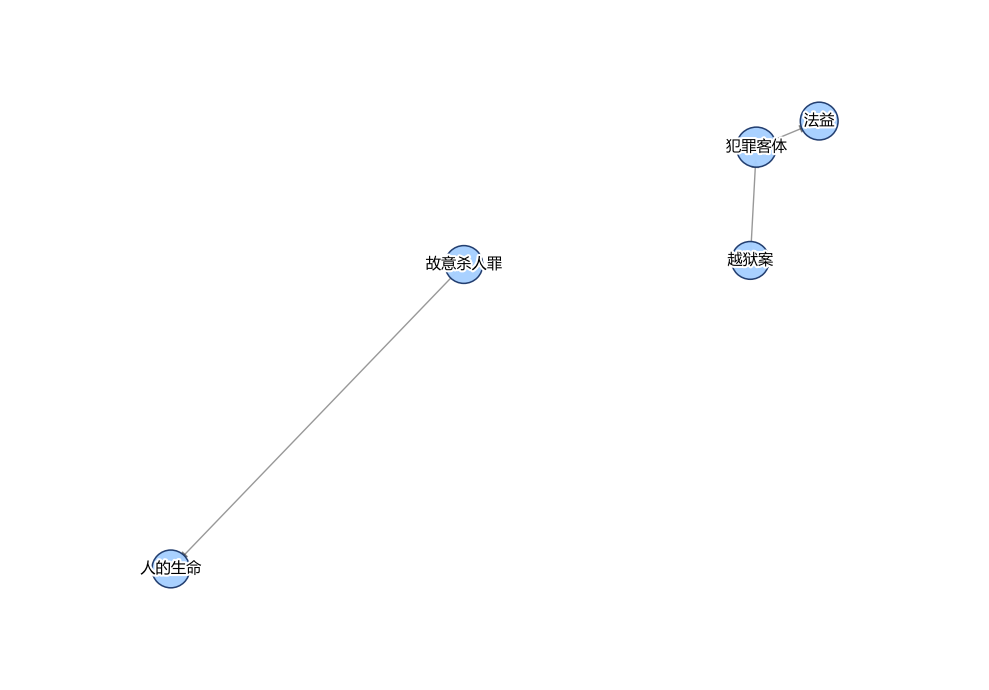

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_baseline_clean.png


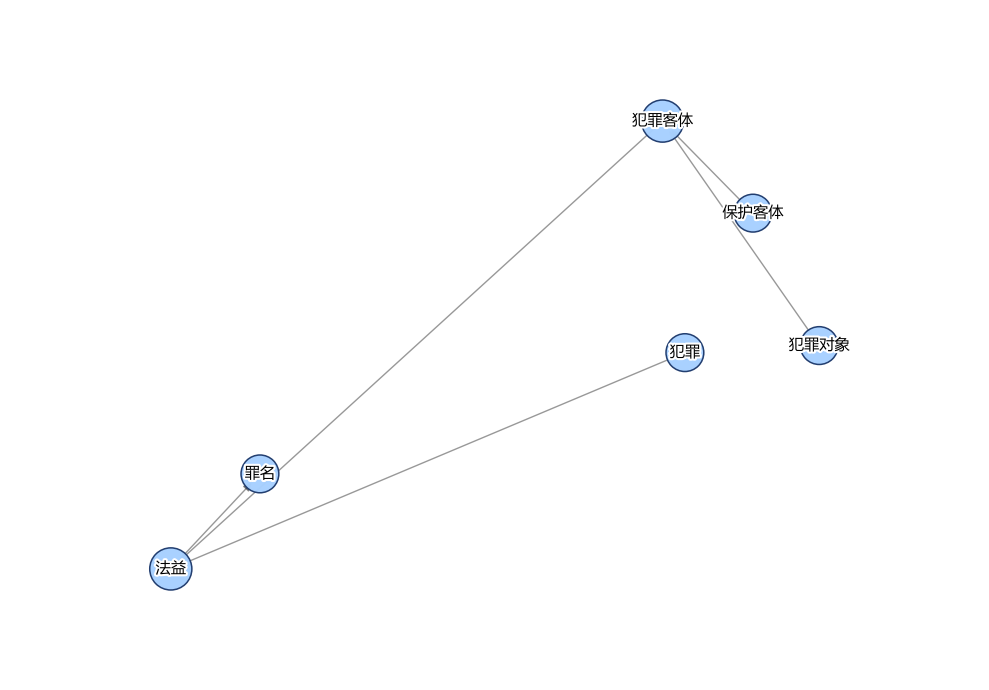

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_truth_clean.png


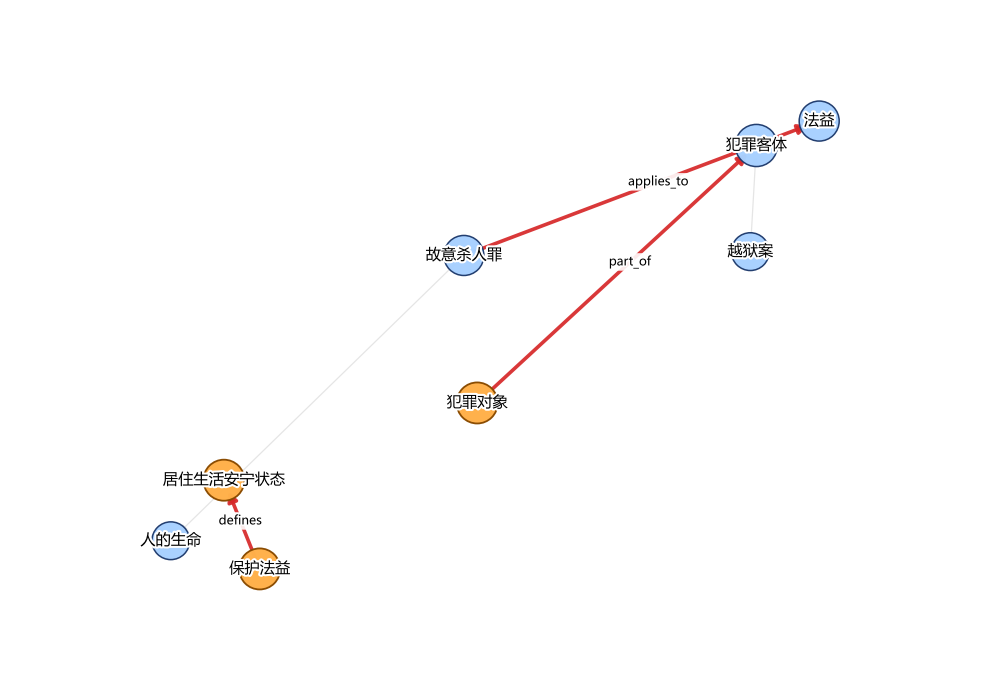

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_updated_clean.png
[Focus] nodes=10, added_edges=3, removed_edges=0
[Saved]
- D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_baseline_clean.png
- D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_truth_clean.png
- D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_updated_clean.png


In [22]:
import os
import re
import textwrap
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import matplotlib.patheffects as pe
import math

# =========================================================
# 0) 路径配置
# =========================================================
i = 2

BASE_NODES  = rf"D:\Desktop\KG_allprocess\Output\Step4_output\test{i}_KG_nodes.tsv"
BASE_EDGES  = rf"D:\Desktop\KG_allprocess\Output\Step4_output\test{i}_KG_edges.tsv"

UPD_NODES   = rf"D:\Desktop\KG_allprocess\Output\Step12_output\test{i}_KG_nodes_updated.tsv"
UPD_EDGES   = rf"D:\Desktop\KG_allprocess\Output\Step12_output\test{i}_KG_edges_updated.tsv"

TRUTH_NODES = rf"D:\Desktop\KG_allprocess\Output\Step4.5_output\test{i}_KG_nodes.tsv"
TRUTH_EDGES = rf"D:\Desktop\KG_allprocess\Output\Step4.5_output\test{i}_KG_edges.tsv"

OUT_DIR     = r"D:\Desktop\KG_allprocess\Output\Step5_output\Figures"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_BASELINE = os.path.join(OUT_DIR, f"test{i}_kg_focus_baseline_clean.png")
OUT_TRUTH    = os.path.join(OUT_DIR, f"test{i}_kg_focus_truth_clean.png")
OUT_UPDATED  = os.path.join(OUT_DIR, f"test{i}_kg_focus_updated_clean.png")

# 聚焦参数
K_HOP     = 1
MAX_NODES = 10

# 列名
NODE_NAME_COL = "name"
EDGE_SRC_COL  = "src_id"
EDGE_DST_COL  = "dst_id"
EDGE_REL_COL  = "relation_type"
NODE_ID_COL_CANDIDATES = ["id", "node_id", "entity_id", "nid"]

# =========================================================
# ✅ 干净 + 防重叠 的开关
# =========================================================
DROP_ISOLATES     = True    # 去掉孤立点
SHOW_TITLE        = False   # 论文图一般关掉
SHOW_STATS        = False   # 角标统计一般关掉
SHOW_EDGE_LABELS  = True    # 只显示新增边标签；更干净可 False
EDGE_STYLE_SIMPLE = True    # True: 直线（更干净）；False: 弧线（更美观）

# 标签控制
LABEL_WRAP_WIDTH  = 8       # 节点标签换行宽度（越小越容易换行）
LABEL_MAX_LINES   = 2       # 节点标签最多行数
EDGE_LABEL_FONT   = 9
NODE_LABEL_FONT   = 11

# 防重叠：位置扩散参数（关键！）
LAYOUT_SEED       = 42
SPRING_K_FACTOR   = 2.6     # 越大越分散（建议 2.2~3.0）
SPRING_ITERS      = 900
MIN_NODE_DIST     = 0.22    # 最小节点间距（越大越不挤，建议 0.18~0.30）
REPULSE_STEPS     = 250     # 扩散迭代次数

# 中文字体
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


# =========================================================
# 1) 读图
# =========================================================
def load_kg_from_tsv(
    nodes_tsv,
    edges_tsv,
    directed=True,
    node_id_col=None,
    node_name_col="name",
    src_col="src_id",
    dst_col="dst_id",
    rel_col="relation_type",
):
    nodes = pd.read_csv(nodes_tsv, sep="\t")
    edges = pd.read_csv(edges_tsv, sep="\t")

    if node_id_col is None:
        for cand in NODE_ID_COL_CANDIDATES:
            if cand in nodes.columns:
                node_id_col = cand
                break
    if node_id_col is None or node_id_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到节点ID列。当前列={list(nodes.columns)}")

    for c in [src_col, dst_col, rel_col]:
        if c not in edges.columns:
            raise ValueError(f"[edges] 找不到列 '{c}'，当前列={list(edges.columns)}")
    if node_name_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到实体名列 '{node_name_col}'，当前列={list(nodes.columns)}")

    G = nx.DiGraph() if directed else nx.Graph()

    for _, r in nodes.iterrows():
        nid = str(r[node_id_col])
        name = str(r[node_name_col]) if pd.notna(r[node_name_col]) else nid
        name = name.strip() if isinstance(name, str) else str(name)
        if not name:
            name = nid
        attrs = r.to_dict()
        attrs["display_name"] = name
        G.add_node(nid, **attrs)

    for _, r in edges.iterrows():
        u = str(r[src_col])
        v = str(r[dst_col])
        rel = str(r[rel_col]) if pd.notna(r[rel_col]) else ""
        rel = rel.strip() if isinstance(rel, str) else str(rel)
        if not rel:
            rel = "?"
        G.add_edge(u, v, relation=rel)

    return G


def edge_keyset(G):
    s = set()
    for u, v, d in G.edges(data=True):
        s.add((u, d.get("relation", ""), v))
    return s


def make_union_graph(*graphs):
    U = nx.DiGraph()
    for g in graphs:
        U.add_nodes_from(g.nodes(data=True))
        U.add_edges_from(g.edges(data=True))
    return U


# =========================================================
# 2) k-hop 聚焦
# =========================================================
def k_hop_nodes(G_union, seeds, k=2, max_nodes=60):
    seeds = [s for s in seeds if s in G_union]
    if not seeds:
        return set()

    visited = set(seeds)
    q = deque([(s, 0) for s in seeds])

    while q:
        node, dist = q.popleft()
        if dist == k:
            continue

        neighbors = set(G_union.successors(node)) | set(G_union.predecessors(node))
        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))
                if max_nodes is not None and len(visited) >= max_nodes:
                    return visited
    return visited


# =========================================================
# 3) ✅ 去重：同名节点合并（解决“犯罪客体”重复）
# =========================================================
def _norm_name(name: str) -> str:
    s = str(name) if name is not None else ""
    s = s.strip()
    s = s.replace("\u3000", " ")
    s = re.sub(r"\s+", " ", s)
    s = s.lower()
    return s

def dedup_graph_by_display_name(G: nx.DiGraph, name_attr="display_name", keep="degree") -> nx.DiGraph:
    buckets = {}
    for n, data in G.nodes(data=True):
        nm = _norm_name(data.get(name_attr, n))
        buckets.setdefault(nm, []).append(n)

    rep_of = {}
    for nm, nodes in buckets.items():
        if len(nodes) == 1:
            rep_of[nodes[0]] = nodes[0]
            continue

        if keep == "degree":
            deg = dict(G.degree(nodes))
            rep = max(nodes, key=lambda x: deg.get(x, 0))
        else:
            rep = nodes[0]
        for x in nodes:
            rep_of[x] = rep

    H = nx.DiGraph()

    reps = set(rep_of.values())
    for r in reps:
        H.add_node(r, **G.nodes[r])

    seen = set()
    for u, v, d in G.edges(data=True):
        ru = rep_of.get(u, u)
        rv = rep_of.get(v, v)
        rel = d.get("relation", "")
        if ru == rv:
            continue
        key = (ru, rel, rv)
        if key in seen:
            continue
        seen.add(key)
        H.add_edge(ru, rv, **d)

    return H


# =========================================================
# 4) 标签与样式辅助
# =========================================================
def _wrap_label(s, width=8, max_lines=2):
    s = str(s).replace("\n", " ").strip()
    if not s:
        return ""
    lines = textwrap.wrap(s, width=width)
    if len(lines) > max_lines:
        lines = lines[:max_lines]
        lines[-1] = (lines[-1][:-1] + "…") if len(lines[-1]) > 1 else "…"
    return "\n".join(lines)

def _node_labels_wrapped(G):
    return {n: _wrap_label(G.nodes[n].get("display_name", str(n)),
                           width=LABEL_WRAP_WIDTH, max_lines=LABEL_MAX_LINES)
            for n in G.nodes()}

def _edge_labels(G):
    return {(u, v): d.get("relation", "") for u, v, d in G.edges(data=True)}

def _draw_labels_with_outline(G, ax, pos, labels, font_size=10):
    texts = nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=font_size)
    for t in texts.values():
        t.set_path_effects([pe.withStroke(linewidth=3, foreground="white")])
    return texts

def _node_sizes_by_degree(G, base=650, scale=90, cap=1300):
    deg = dict(G.degree())
    return {n: min(cap, base + scale * deg.get(n, 0)) for n in G.nodes()}

def _maybe_drop_isolates(G):
    if not DROP_ISOLATES:
        return G
    iso = list(nx.isolates(G))
    if not iso:
        return G
    H = G.copy()
    H.remove_nodes_from(iso)
    return H


# =========================================================
# 5) ✅ 防重叠：位置扩散（强制最小间距）
# =========================================================
def _spread_positions(pos: dict, min_dist=0.22, steps=200, step_size=0.02, seed=42):
    """
    在现有 pos 上做 repulsion，让任意两点距离至少 min_dist（小图非常有效）
    - O(n^2) 但 n<=~20 时很快
    """
    import random
    random.seed(seed)

    nodes = list(pos.keys())
    p = {n: [float(pos[n][0]), float(pos[n][1])] for n in nodes}

    for _ in range(steps):
        moved = False
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                a, b = nodes[i], nodes[j]
                dx = p[a][0] - p[b][0]
                dy = p[a][1] - p[b][1]
                dist = math.sqrt(dx*dx + dy*dy) + 1e-9
                if dist < min_dist:
                    # 推开：沿连线方向
                    push = (min_dist - dist) * 0.5
                    ux, uy = dx / dist, dy / dist
                    p[a][0] += ux * push
                    p[a][1] += uy * push
                    p[b][0] -= ux * push
                    p[b][1] -= uy * push
                    moved = True
        if not moved:
            break

    # 轻微拉伸，让整体更舒展
    xs = [p[n][0] for n in nodes]
    ys = [p[n][1] for n in nodes]
    cx, cy = sum(xs)/len(xs), sum(ys)/len(ys)
    for n in nodes:
        p[n][0] = cx + (p[n][0] - cx) * 1.10
        p[n][1] = cy + (p[n][1] - cy) * 1.10

    return {n: (p[n][0], p[n][1]) for n in nodes}


def compute_clean_layout(G, seed=42):
    """
    先 spring_layout（更分散），再 spread_positions 强制最小间距。
    """
    n = max(1, G.number_of_nodes())
    k = (SPRING_K_FACTOR / (n ** 0.5))
    pos = nx.spring_layout(G, seed=seed, k=k, iterations=SPRING_ITERS)
    pos = _spread_positions(pos, min_dist=MIN_NODE_DIST, steps=REPULSE_STEPS, seed=seed)
    return pos


# =========================================================
# 6) 绘图
# =========================================================
def draw_clean_graph(G, pos, title, out_path):
    G = _maybe_drop_isolates(G)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    if SHOW_TITLE:
        ax.set_title(title, fontsize=14, pad=10)
    ax.axis("off")

    node_sizes = _node_sizes_by_degree(G)

    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        nodelist=list(G.nodes()),
        node_size=[node_sizes[n] for n in G.nodes()],
        node_color="#A7D0FF",
        edgecolors="#1F3B6D",
        linewidths=1.1,
        alpha=0.98
    )

    edge_kwargs = dict(
        edge_color="#333333",
        width=1.0,
        alpha=0.50,
        arrows=True,
        arrowsize=12,
        arrowstyle='-|>'
    )
    if EDGE_STYLE_SIMPLE:
        nx.draw_networkx_edges(G, pos, ax=ax, **edge_kwargs)
    else:
        nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle="arc3,rad=0.12", **edge_kwargs)

    labels = _node_labels_wrapped(G)
    _draw_labels_with_outline(G, ax, pos, labels, font_size=NODE_LABEL_FONT)

    ax.margins(0.18)
    plt.tight_layout()
    plt.savefig(out_path, dpi=450, bbox_inches="tight", facecolor="white")
    plt.show()
    print(f"[Saved] {out_path}")


def draw_updated_highlight_clean(G_base, G_upd, pos, title, out_path):
    G_base = _maybe_drop_isolates(G_base)
    G_upd  = _maybe_drop_isolates(G_upd)

    base_nodes = set(G_base.nodes())
    upd_nodes  = set(G_upd.nodes())

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added_nodes = upd_nodes - base_nodes
    kept_nodes  = upd_nodes & base_nodes

    added_edges = upd_edges - base_edges
    kept_edges  = upd_edges & base_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    if SHOW_TITLE:
        ax.set_title(title, fontsize=14, pad=10)
    ax.axis("off")

    node_sizes = _node_sizes_by_degree(G_upd)

    # 保留边（淡）
    if kept_edges:
        edge_kwargs = dict(
            edge_color="#D0D0D0",
            width=0.9,
            alpha=0.55,
            arrows=True,
            arrowsize=11,
            arrowstyle='-|>'
        )
        if EDGE_STYLE_SIMPLE:
            nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(kept_edges), **edge_kwargs)
        else:
            nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(kept_edges),
                                   connectionstyle="arc3,rad=0.10", **edge_kwargs)

    # 新增边（红色）
    if added_edges:
        edge_kwargs = dict(
            edge_color="#D62728",
            width=2.6,
            alpha=0.92,
            arrows=True,
            arrowsize=14,
            arrowstyle='-|>'
        )
        if EDGE_STYLE_SIMPLE:
            nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(added_edges), **edge_kwargs)
        else:
            nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(added_edges),
                                   connectionstyle="arc3,rad=0.16", **edge_kwargs)

    # 节点：保留浅蓝
    if kept_nodes:
        nx.draw_networkx_nodes(
            G_upd, pos, ax=ax,
            nodelist=list(kept_nodes),
            node_size=[node_sizes[n] for n in kept_nodes],
            node_color="#A7D0FF",
            edgecolors="#1F3B6D",
            linewidths=1.1,
            alpha=0.98
        )

    # 新增节点：橙色更醒目
    if added_nodes:
        nx.draw_networkx_nodes(
            G_upd, pos, ax=ax,
            nodelist=list(added_nodes),
            node_size=[min(1500, int(node_sizes[n] * 1.18)) for n in added_nodes],
            node_color="#FFB04A",
            edgecolors="#8A4B00",
            linewidths=1.3,
            alpha=0.99
        )

    # 节点标签
    labels = _node_labels_wrapped(G_upd)
    _draw_labels_with_outline(G_upd, ax, pos, labels, font_size=NODE_LABEL_FONT)

    # 只给新增边打标签（可开关）
    if SHOW_EDGE_LABELS and added_edges:
        added_edge_labels = {(u, v): rel for (u, rel, v) in added_edges}
        texts = nx.draw_networkx_edge_labels(
            G_upd, pos, ax=ax,
            edge_labels=added_edge_labels,
            font_size=EDGE_LABEL_FONT,
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.9),
            rotate=False,
            label_pos=0.55
        )
        for t in texts.values():
            t.set_path_effects([pe.withStroke(linewidth=2, foreground="white")])

    if SHOW_STATS:
        ax.text(
            0.01, 0.01,
            f"added_nodes={len(added_nodes)}, added_edges={len(added_edges)}",
            transform=ax.transAxes, fontsize=10, va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.85)
        )

    ax.margins(0.18)
    plt.tight_layout()
    plt.savefig(out_path, dpi=450, bbox_inches="tight", facecolor="white")
    plt.show()
    print(f"[Saved] {out_path}")


# =========================================================
# 7) 主流程：去重 + focus + 三图输出
# =========================================================
def plot_three_figures_clean(k=1, max_nodes=10, seed=42):
    G_base  = load_kg_from_tsv(BASE_NODES,  BASE_EDGES,
                              node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_upd   = load_kg_from_tsv(UPD_NODES,   UPD_EDGES,
                              node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_truth = load_kg_from_tsv(TRUTH_NODES, TRUTH_EDGES,
                              node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)

    # ✅ 去重：合并同名节点（解决“犯罪客体”重复）
    G_base  = dedup_graph_by_display_name(G_base)
    G_upd   = dedup_graph_by_display_name(G_upd)
    G_truth = dedup_graph_by_display_name(G_truth)

    # 变化边端点作为 focus seed
    base_e = edge_keyset(G_base)
    upd_e  = edge_keyset(G_upd)
    added  = upd_e - base_e
    removed = base_e - upd_e

    changed_nodes = set()
    for (u, rel, v) in list(added) + list(removed):
        changed_nodes.add(u)
        changed_nodes.add(v)

    if not changed_nodes:
        print("[Warn] 未检测到变化边，将使用 Updated 的前若干节点作为 focus。")
        changed_nodes = set(list(G_upd.nodes())[:min(len(G_upd.nodes()), 5)])

    # union 上做 k-hop 扩散
    G_union = make_union_graph(G_base, G_upd, G_truth)
    focus_nodes = k_hop_nodes(G_union, changed_nodes, k=k, max_nodes=None)

    # 裁剪：优先保留 changed_nodes，其余按度数高优先
    if max_nodes is not None and len(focus_nodes) > max_nodes:
        focus_list = list(focus_nodes)
        deg = dict(G_union.degree())
        focus_list.sort(key=lambda n: (n not in changed_nodes, -deg.get(n, 0)))
        focus_nodes = set(focus_list[:max_nodes])

    base_sub  = G_base.subgraph(focus_nodes).copy()
    upd_sub   = G_upd.subgraph(focus_nodes).copy()
    truth_sub = G_truth.subgraph(focus_nodes).copy()

    # ✅ 统一布局：在 focus 的 union 子图上算一次 pos
    union_sub = make_union_graph(base_sub, upd_sub, truth_sub)
    union_sub = _maybe_drop_isolates(union_sub)

    pos = compute_clean_layout(union_sub, seed=seed)

    # 绘图输出
    draw_clean_graph(base_sub,  pos, f"Baseline (focus, k={k})", OUT_BASELINE)
    draw_clean_graph(truth_sub, pos, f"Truth (focus, k={k})",    OUT_TRUTH)
    draw_updated_highlight_clean(base_sub, upd_sub, pos, f"Updated (highlight, focus, k={k})", OUT_UPDATED)

    print(f"[Focus] nodes={len(focus_nodes)}, added_edges={len(added)}, removed_edges={len(removed)}")
    print(f"[Saved]\n- {OUT_BASELINE}\n- {OUT_TRUTH}\n- {OUT_UPDATED}")


if __name__ == "__main__":
    plot_three_figures_clean(k=K_HOP, max_nodes=MAX_NODES, seed=LAYOUT_SEED)


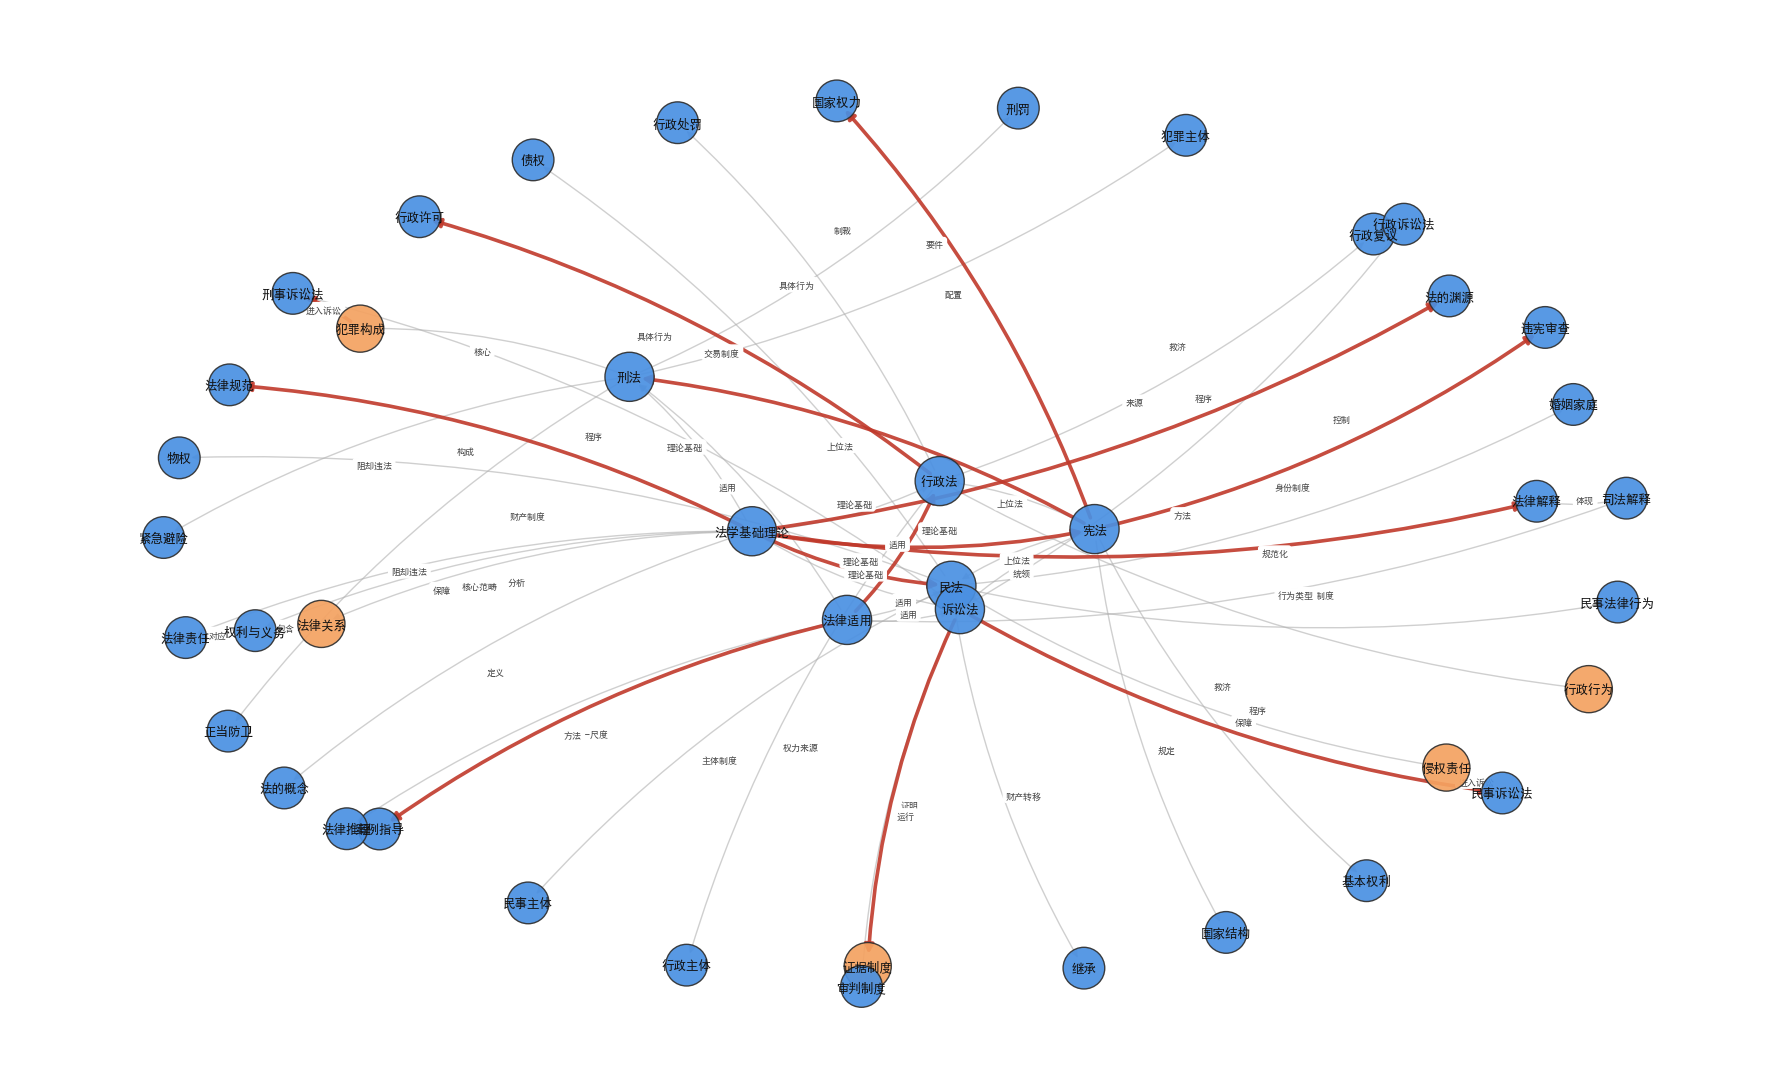

In [29]:
# -*- coding: utf-8 -*-
import random
import networkx as nx
import matplotlib.pyplot as plt

# ========= 可调参数 =========
SEED = 42
NUM_IMPORTANT_EDGES = 14   # 红色加粗边数量（随机）
SHOW_EDGE_LABELS = True    # 是否显示边的关系标签
SHOW_NODE_LABELS = True    # 是否显示节点文字（想要像示例图可设为 False）
FIGSIZE = (18, 11)

random.seed(SEED)

# ========= 1) 构建图 =========
G = nx.DiGraph()

# 核心节点（重要但不染橙色，只做“略大”）
core_nodes = ["法学基础理论", "宪法", "民法", "刑法", "行政法", "诉讼法", "法律适用"]

# 其他节点（约40+）
other_nodes = [
    # 基础理论
    "法的概念","法律规范","法律关系","权利与义务","法律责任","法的渊源","法律解释",
    # 宪法
    "国家结构","基本权利","国家权力","违宪审查",
    # 民法
    "民事主体","民事法律行为","物权","债权","侵权责任","婚姻家庭","继承",
    # 刑法
    "犯罪构成","犯罪主体","刑罚","正当防卫","紧急避险",
    # 行政法
    "行政主体","行政行为","行政许可","行政处罚","行政复议",
    # 诉讼法
    "民事诉讼法","刑事诉讼法","行政诉讼法","证据制度","审判制度",
    # 法律适用
    "司法解释","案例指导","法律推理"
]
G.add_nodes_from(core_nodes + other_nodes)

# 边（关系）
edges_with_rel = [
    # 基础理论 -> 子概念
    ("法学基础理论","法的概念","定义"),
    ("法学基础理论","法律规范","构成"),
    ("法学基础理论","法律关系","分析"),
    ("法学基础理论","权利与义务","核心范畴"),
    ("法学基础理论","法律责任","保障"),
    ("法学基础理论","法的渊源","来源"),
    ("法学基础理论","法律解释","方法"),

    # 宪法 -> 子概念
    ("宪法","国家结构","规定"),
    ("宪法","基本权利","保障"),
    ("宪法","国家权力","配置"),
    ("宪法","违宪审查","控制"),

    # 民法 -> 子概念
    ("民法","民事主体","主体制度"),
    ("民法","民事法律行为","行为制度"),
    ("民法","物权","财产制度"),
    ("民法","债权","交易制度"),
    ("民法","侵权责任","救济"),
    ("民法","婚姻家庭","身份制度"),
    ("民法","继承","财产转移"),

    # 刑法 -> 子概念
    ("刑法","犯罪构成","核心"),
    ("刑法","犯罪主体","要件"),
    ("刑法","刑罚","制裁"),
    ("刑法","正当防卫","阻却违法"),
    ("刑法","紧急避险","阻却违法"),

    # 行政法 -> 子概念
    ("行政法","行政主体","权力来源"),
    ("行政法","行政行为","行为类型"),
    ("行政法","行政许可","具体行为"),
    ("行政法","行政处罚","具体行为"),
    ("行政法","行政复议","救济"),

    # 诉讼法 -> 子概念
    ("诉讼法","民事诉讼法","程序"),
    ("诉讼法","刑事诉讼法","程序"),
    ("诉讼法","行政诉讼法","程序"),
    ("诉讼法","证据制度","证明"),
    ("诉讼法","审判制度","运行"),

    # 法律适用 -> 子概念
    ("法律适用","司法解释","规范化"),
    ("法律适用","案例指导","统一尺度"),
    ("法律适用","法律推理","方法"),

    # 横向联系（网状）
    ("法律关系","权利与义务","包含"),
    ("权利与义务","法律责任","对应"),
    ("法律解释","司法解释","体现"),
    ("案例指导","法律推理","支持"),
    ("证据制度","审判制度","支撑"),
    ("行政复议","行政诉讼法","衔接"),
    ("侵权责任","民事诉讼法","进入诉讼"),
    ("犯罪构成","刑事诉讼法","进入诉讼"),

    # 上位法/统领/适用
    ("宪法","民法","上位法"),
    ("宪法","刑法","上位法"),
    ("宪法","行政法","上位法"),
    ("宪法","诉讼法","统领"),
    ("法学基础理论","宪法","理论基础"),
    ("法学基础理论","民法","理论基础"),
    ("法学基础理论","刑法","理论基础"),
    ("法学基础理论","行政法","理论基础"),
    ("法学基础理论","诉讼法","理论基础"),
    ("法律适用","民法","适用"),
    ("法律适用","刑法","适用"),
    ("法律适用","行政法","适用"),
    ("法律适用","诉讼法","适用"),
]

for u, v, rel in edges_with_rel:
    G.add_edge(u, v, rel=rel)

all_edges = list(G.edges())

# ========= 2) 随机挑红色加粗边（分散） =========
k_edges = min(NUM_IMPORTANT_EDGES, len(all_edges))
important_edges = set(random.sample(all_edges, k=k_edges))
red_edges = [e for e in all_edges if e in important_edges]
general_edges = [e for e in all_edges if e not in important_edges]

# ========= 3) 橙色节点（更少 + 不包含核心节点） =========
# 这里选“制度枢纽”节点，数量少但更有信息价值；你也可以自行增删
orange_nodes = {
    "法律关系",
    "侵权责任",
    "犯罪构成",
    "行政行为",
    "证据制度"
}

# ========= 4) 力导向布局（自然散开） =========
pos = nx.spring_layout(G, seed=SEED, k=0.9, iterations=500)

# ========= 5) 画图 =========
plt.figure(figsize=FIGSIZE)

# 更学术的配色
BLUE = "#4A90E2"       # 学术蓝
ORANGE = "#F4A261"     # 柔和橙
EDGE_GRAY = "#B0B0B0"  # 更淡灰
RED = "#C0392B"        # 深红

# 节点颜色（核心节点不橙）
node_colors = [ORANGE if n in orange_nodes else BLUE for n in G.nodes()]

# 节点大小：核心节点略大（不靠颜色强调）
node_sizes = []
for n in G.nodes():
    if n in core_nodes:
        node_sizes.append(1250)
    elif n in orange_nodes:
        node_sizes.append(1150)
    else:
        node_sizes.append(900)

# 画节点
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="#2f2f2f",
    linewidths=1.0,
    alpha=0.92
)

# 节点文字（想要像示例图“只看关系”可改 SHOW_NODE_LABELS=False）
if SHOW_NODE_LABELS:
    nx.draw_networkx_labels(
        G, pos,
        font_size=9,
        font_family="SimHei",
        font_color="#111111"
    )

# 灰边（默认）
nx.draw_networkx_edges(
    G, pos,
    edgelist=general_edges,
    edge_color=EDGE_GRAY,
    width=1.0,
    arrows=True,
    arrowsize=10,
    alpha=0.6,
    connectionstyle="arc3,rad=0.10"
)

# 红边（重点）
nx.draw_networkx_edges(
    G, pos,
    edgelist=red_edges,
    edge_color=RED,
    width=2.6,
    arrows=True,
    arrowsize=13,
    alpha=0.9,
    connectionstyle="arc3,rad=0.10"
)

# 边标签（关系文字）
if SHOW_EDGE_LABELS:
    edge_labels = {(u, v): G[u][v].get("rel", "") for (u, v) in G.edges()}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=6.5,
        font_family="SimHei",
        font_color="#444444",
        rotate=False,
        label_pos=0.55
    )

# plt.title("法学知识图谱（蓝=节点；橙=少量制度枢纽；灰边=一般关系；红边=随机重点关系）", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

# 保存（可选）
# plt.savefig("law_graph_beautified.png", dpi=300, bbox_inches="tight")
